In [121]:
import numpy as np
import phoebe
from phoebe import u, c

import scienceplots
import matplotlib.pyplot as plt
plt.style.use("science")

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils

logger = phoebe.logger(clevel='WARNING')

In [122]:
# helper variables
gaiaDatasets = ['lcGaiaG', 'lcGaiaRP', 'lcGaiaBP']
iturbideDatasets = ['lcIturbideAviles', 'lcIturbideFull']
ztfDatasets = ['lcZtfG', 'lcZtfR']
# trimmedZtfDatasets = ['lcZtfGTrimmed', 'lcZtfRTrimmed']
allDatasets = gaiaDatasets + iturbideDatasets + ztfDatasets
# plotAllDatasetsGroups = [['lcIturbideAviles'], ['lcIturbideFull'], gaiaDatasets, ztfDatasets]
plotAllDatasetsGroups = [['lcIturbide'], gaiaDatasets, ztfDatasets]

In [123]:
b = gen_utils.loadBundle(bundleName='post-optimizers', parentFolder='../optimizers', subfolder="updated-data")

In [125]:
b.datasets

['mesh01',
 'lc_iturbide_norm',
 'lc_gaia_g_raw',
 'lc_gaia_rp_raw',
 'lc_gaia_bp_raw',
 'lcZtfG',
 'lcZtfR']

In [127]:
# b.add_dataset('lc', dataset='lcGaiaG', overwrite=True, passband='Gaia:G', 
# 			  times=b.get_value(qualifier='times', dataset='lc_gaia_g_raw', context='dataset'),
# 			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_g_raw', context='dataset'),
# 			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_g_raw', context='dataset'),
# 			  pblum_mode='component-coupled', pblum=b.get_value(qualifier='pblum', dataset='lc_gaia_g_raw'))
b.add_dataset('lc', dataset='lcGaiaG', overwrite=True, passband='Gaia:G', 
			  times=b.get_value(qualifier='times', dataset='lc_gaia_g_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_g_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_g_raw', context='dataset'),
			  pblum_mode='dataset-scaled')
b.add_dataset('lc', dataset='lcGaiaRP', overwrite=True, passband='Gaia:RP',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_rp_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_rp_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_rp_raw', context='dataset'),
			  pblum_mode='dataset-coupled', pblum_dataset='lcGaiaG')
b.add_dataset('lc', dataset='lcGaiaBP', overwrite=True, passband='Gaia:BP',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_bp_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_bp_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_bp_raw', context='dataset'),
			  pblum_mode='dataset-coupled', pblum_dataset='lcGaiaG')

b.add_dataset('lc', dataset='lcIturbide', overwrite=True, pblum_mode='dataset-scaled',
			  times=b.get_value(qualifier='times', dataset='lc_iturbide_norm', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_iturbide_norm', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_iturbide_norm', context='dataset'))

<ParameterSet: 47 parameters | contexts: compute, constraint, figure, dataset>

In [128]:
b.datasets

['mesh01',
 'lc_iturbide_norm',
 'lc_gaia_g_raw',
 'lc_gaia_rp_raw',
 'lc_gaia_bp_raw',
 'lcZtfG',
 'lcZtfR',
 'lcGaiaG',
 'lcGaiaRP',
 'lcGaiaBP',
 'lcIturbide']

In [129]:
%%script echo "skip setting interstellar extinction"
b.flip_constraint(qualifier='ebv', solve_for='Av')

skip setting interstellar extinction


In [130]:
%%script echo "skip setting interstellar extinction"
b.set_value(qualifier='ebv', value=0.1526) # IRSA SFD (1998) max

skip setting interstellar extinction


In [131]:
gen_utils.abilitateDatasets(b, enableDatasets=ztfDatasets + gaiaDatasets, includeMesh=False)
b.set_value_all(qualifier='compute_phases', dataset=ztfDatasets, value=[])
b.run_compute(model='before_data_removal', overwrite=True)

100%|██████████| 1865/1865 [07:27<00:00,  4.17it/s]


<ParameterSet: 14 parameters | datasets: lcGaiaG, lcZtfR, lcGaiaRP, lcGaiaBP, lcZtfG>

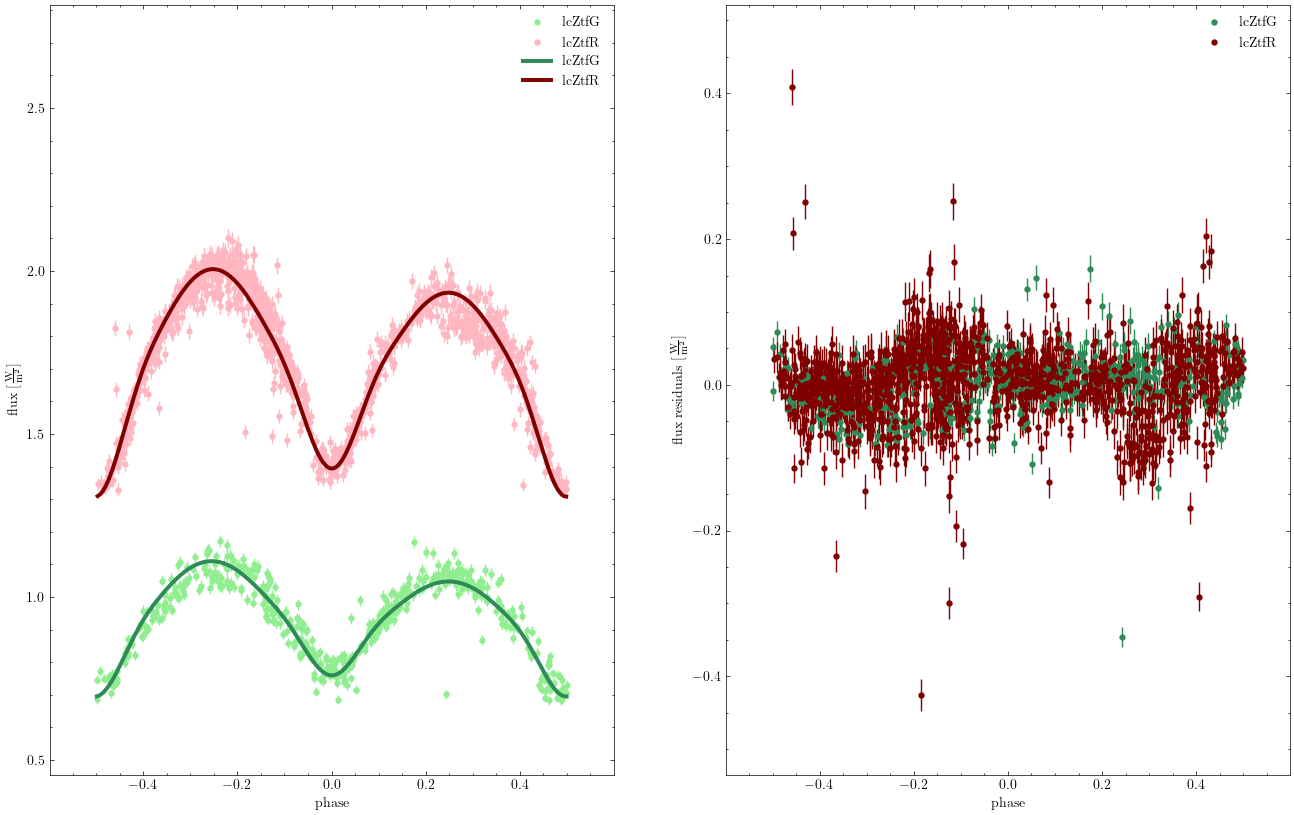

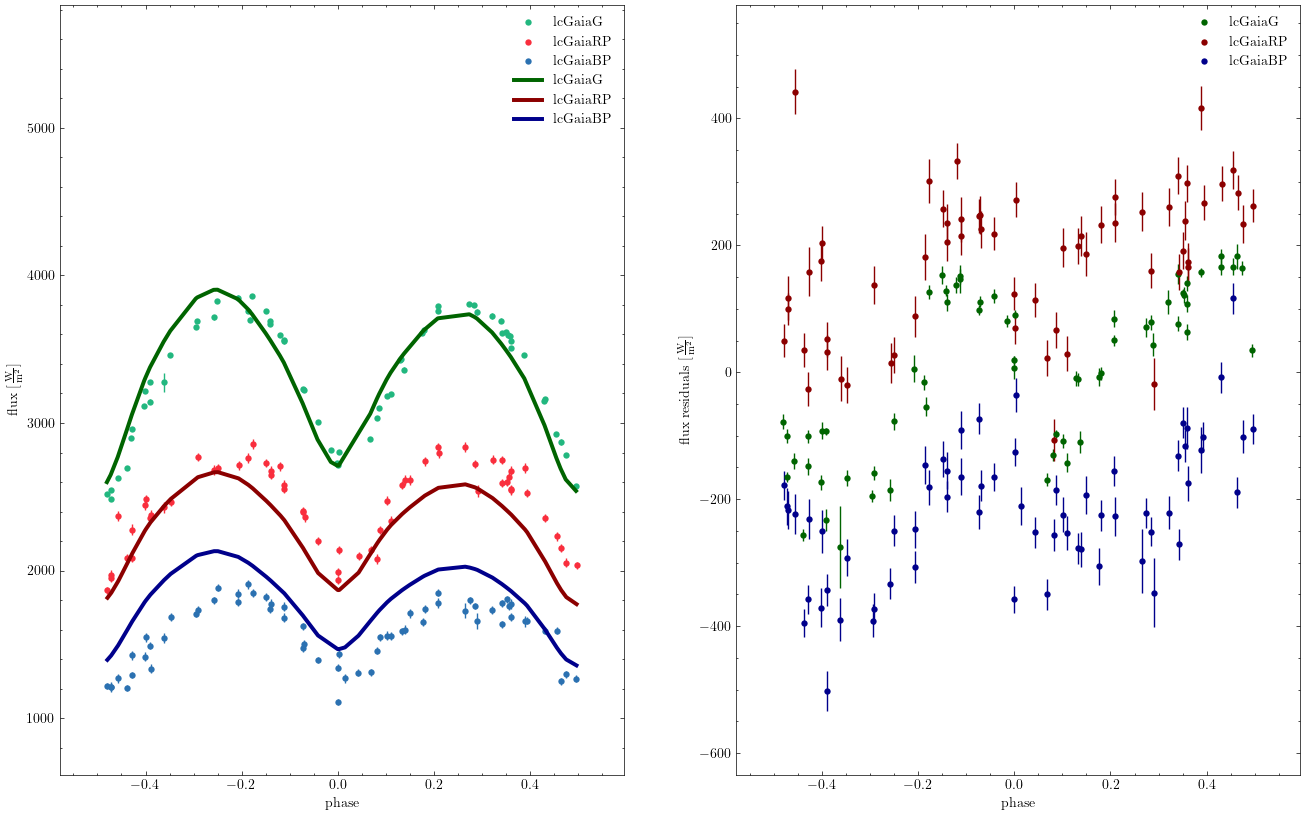

{'lcZtfG-lcZtfR': <Figure size 1600x1000 with 2 Axes>,
 'lcGaiaG-lcGaiaRP-lcGaiaBP': <Figure size 1600x1000 with 2 Axes>}

In [132]:
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[ztfDatasets, gaiaDatasets], model='before_data_removal')

In [133]:
def get_model_residuals(dataset: str, model: str) -> np.ndarray:
	return b.get_value(qualifier='fluxes', dataset=dataset, context='dataset') - b.get_value(qualifier='fluxes', dataset=dataset, model=model)

def plot_residuals(dataset: str, model: str) -> None:
	colors = {
		'lcZtfRTrimmed': 'darkred',
		'lcZtfGTrimmed': 'darkgreen'
	}

	residuals = get_model_residuals(dataset, model)
	
	_, axs = plt.subplots(1, 2, figsize=(22, 10))
	axs[0].hist(residuals, bins=300, color=colors[dataset], label=dataset)
	
	axs[1].plot(b.to_phase(b.get_value(qualifier='times', dataset=dataset, model=model)), residuals, color=colors[dataset], label=dataset, marker='.', linestyle='none')
	# axs[1].plot(b.get_value(qualifier='times', dataset=dataset, model='after_dc_model'), afterDcResiduals, color=colors[dataset], label=dataset, marker='.', linestyle='none')
	axs[1].legend()
	plt.show()

In [134]:
r_residuals = get_model_residuals('lcZtfR', 'before_data_removal')
g_residuals = get_model_residuals('lcZtfG', 'before_data_removal')

JD_0 = 2458255

Text(0, 0.5, 'Flux residuals')

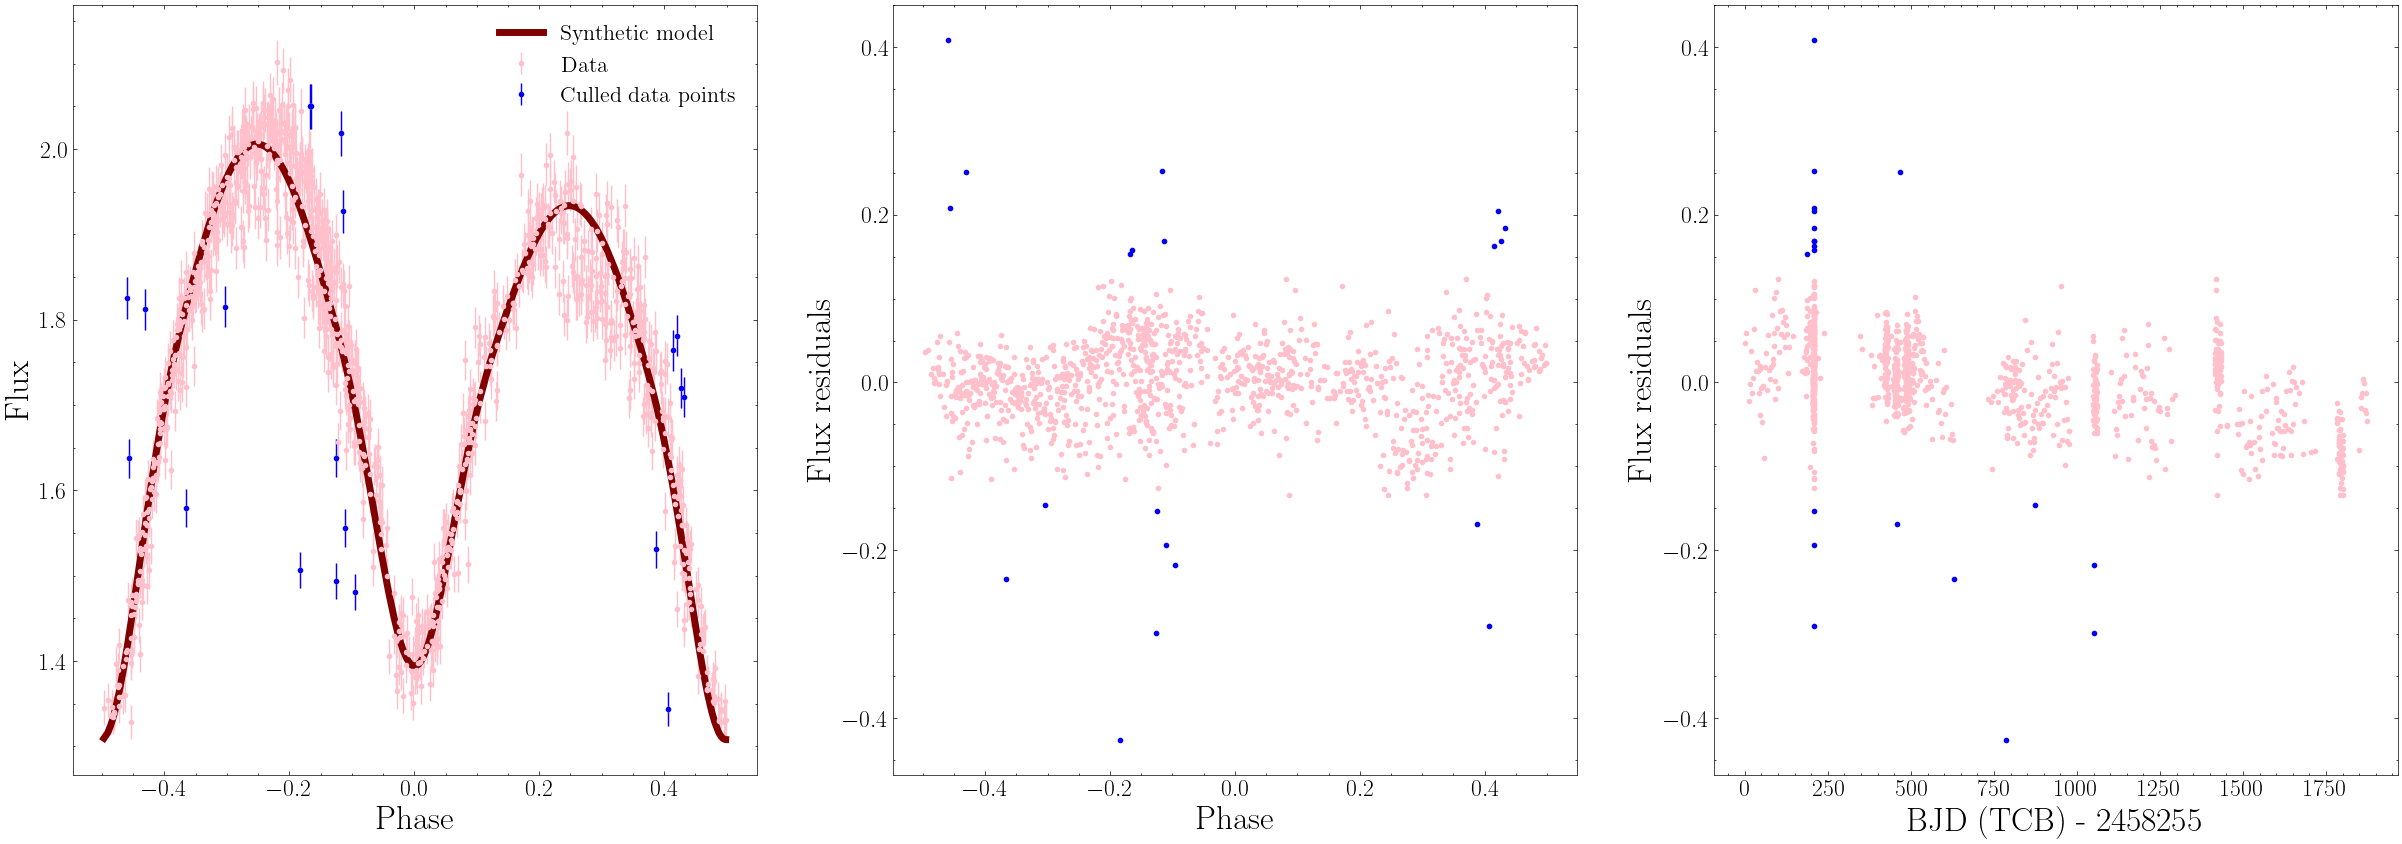

In [135]:
r_std = np.std(r_residuals)
r_mean = np.mean(r_residuals)
# r_meanDistance = np.abs(r_residuals - r_mean)
# r_badMask = np.ma.masked_where(r_meanDistance > 2*r_std, r_meanDistance).mask

r_times = b.get_value(qualifier='times', dataset='lcZtfR', model='before_data_removal')
r_phase = b.to_phase(r_times)
r_dataFlux = b.get_value(qualifier='fluxes', dataset='lcZtfR', context='dataset')
r_dataSigmas = b.get_value(qualifier='sigmas', dataset='lcZtfR', context='dataset')

r_modelFlux = b.get_value(qualifier='fluxes', dataset='lcZtfR', model='before_data_removal')
r_model = list(zip(r_phase, r_modelFlux))
r_model = sorted(r_model, key=lambda m: m[0])

r_badMask = np.ma.masked_where(np.abs(r_modelFlux - r_dataFlux) > 2.5*r_std, r_modelFlux).mask

_, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].errorbar(r_phase, r_dataFlux, r_dataSigmas, color='pink', marker='.', linestyle='none', label='Data')
axs[0].errorbar(r_phase[r_badMask], r_dataFlux[r_badMask], r_dataSigmas[r_badMask], color='blue', marker='.', linestyle='none', label='Culled data points')
axs[0].plot([p for p, _ in r_model], [f for _, f in r_model], c='maroon', lw=5, label='Synthetic model')
axs[0].legend(fontsize=16)

axs[1].plot(r_phase, r_residuals, color='pink', marker='.', linestyle='none')
axs[1].plot(r_phase[r_badMask], r_residuals[r_badMask], color='blue', marker='.', linestyle='none')

axs[2].plot(r_times - JD_0, r_residuals, color='pink', marker='.', linestyle='none')
axs[2].plot(r_times[r_badMask] - JD_0, r_residuals[r_badMask], color='blue', marker='.', linestyle='none')

for ax in axs:
    ax.tick_params(axis='both', labelsize=17)

axs[0].set_xlabel("Phase", fontsize=24)
axs[1].set_xlabel("Phase", fontsize=24)
axs[2].set_xlabel(f"BJD (TCB) - {JD_0}", fontsize=24)

axs[0].set_ylabel("Flux", fontsize=24)
axs[1].set_ylabel("Flux residuals", fontsize=24)
axs[2].set_ylabel("Flux residuals", fontsize=24)

Text(0, 0.5, 'Flux residuals')

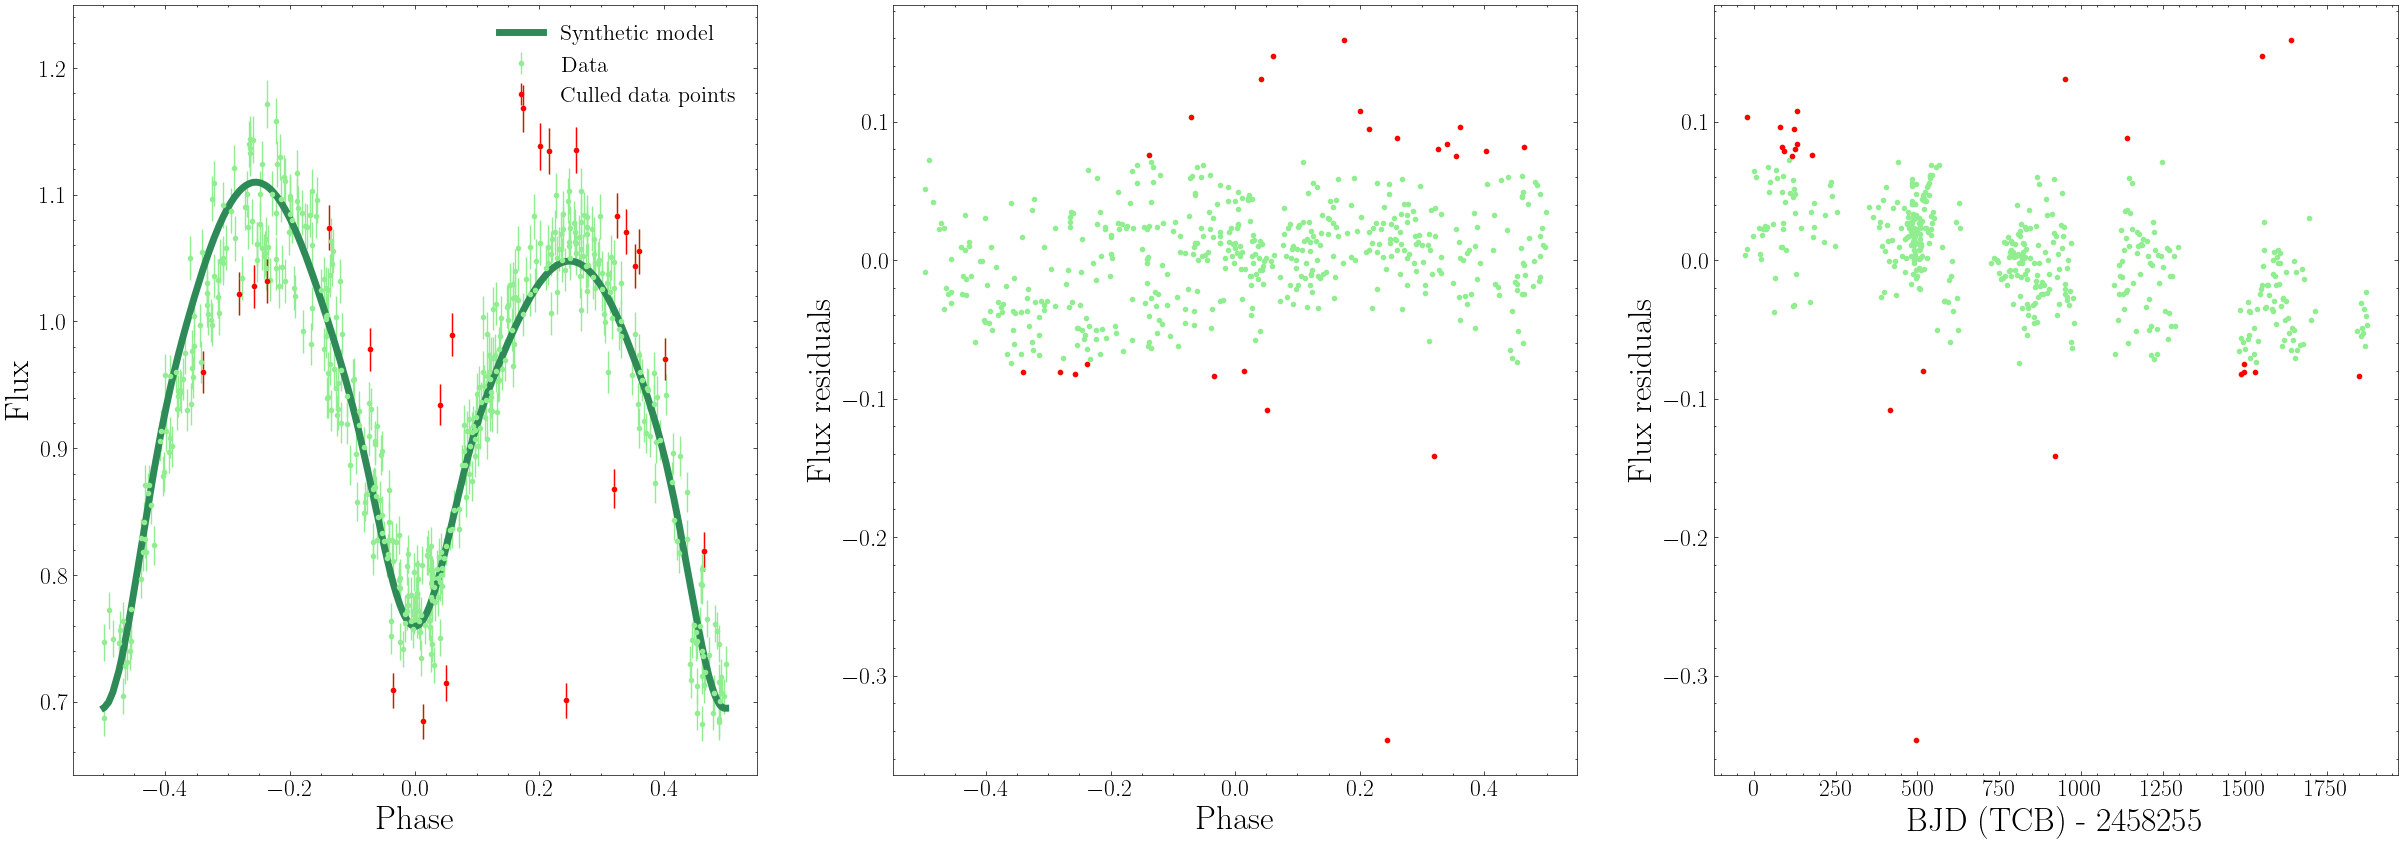

In [136]:
g_std = np.std(g_residuals)
g_mean = np.mean(g_residuals)
# g_meanDistance = np.abs(g_residuals - g_mean)
# g_badMask = np.ma.masked_where(g_meanDistance > 2*g_std, g_meanDistance).mask

g_times = b.get_value(qualifier='times', dataset='lcZtfG', model='before_data_removal')
g_phase = b.to_phase(g_times)
g_dataFlux = b.get_value(qualifier='fluxes', dataset='lcZtfG', context='dataset')
g_dataSigmas = b.get_value(qualifier='sigmas', dataset='lcZtfG', context='dataset')

g_modelFlux = b.get_value(qualifier='fluxes', dataset='lcZtfG', model='before_data_removal')
g_model = list(zip(g_phase, g_modelFlux))
g_model = sorted(g_model, key=lambda m: m[0])

g_badMask = np.ma.masked_where(np.abs(g_modelFlux - g_dataFlux) > 1.8*g_std, g_modelFlux).mask

_, axs = plt.subplots(1, 3, figsize=(30, 10))
# darkgreen
axs[0].errorbar(g_phase, g_dataFlux, g_dataSigmas, color='lightgreen', marker='.', linestyle='none', label='Data')
axs[0].errorbar(g_phase[g_badMask], g_dataFlux[g_badMask], g_dataSigmas[g_badMask], color='red', marker='.', linestyle='none', label='Culled data points')
axs[0].plot([p for p, _ in g_model], [f for _, f in g_model], c='seagreen', lw=5, label='Synthetic model')
axs[0].legend(fontsize=16, loc='upper right')
axs[0].set_ylim((None, 1.25))

axs[1].plot(g_phase, g_residuals, color='lightgreen', marker='.', linestyle='none')
axs[1].plot(g_phase[g_badMask], g_residuals[g_badMask], color='red', marker='.', linestyle='none')

axs[2].plot(g_times - JD_0, g_residuals, color='lightgreen', marker='.', linestyle='none')
axs[2].plot(g_times[g_badMask] - JD_0, g_residuals[g_badMask], color='red', marker='.', linestyle='none')

for ax in axs:
    ax.tick_params(axis='both', labelsize=17)

axs[0].set_xlabel("Phase", fontsize=24)
axs[1].set_xlabel("Phase", fontsize=24)
axs[2].set_xlabel(f"BJD (TCB) - {JD_0}", fontsize=24)

axs[0].set_ylabel("Flux", fontsize=24)
axs[1].set_ylabel("Flux residuals", fontsize=24)
axs[2].set_ylabel("Flux residuals", fontsize=24)

100%|██████████| 1631/1631 [06:27<00:00,  4.21it/s]


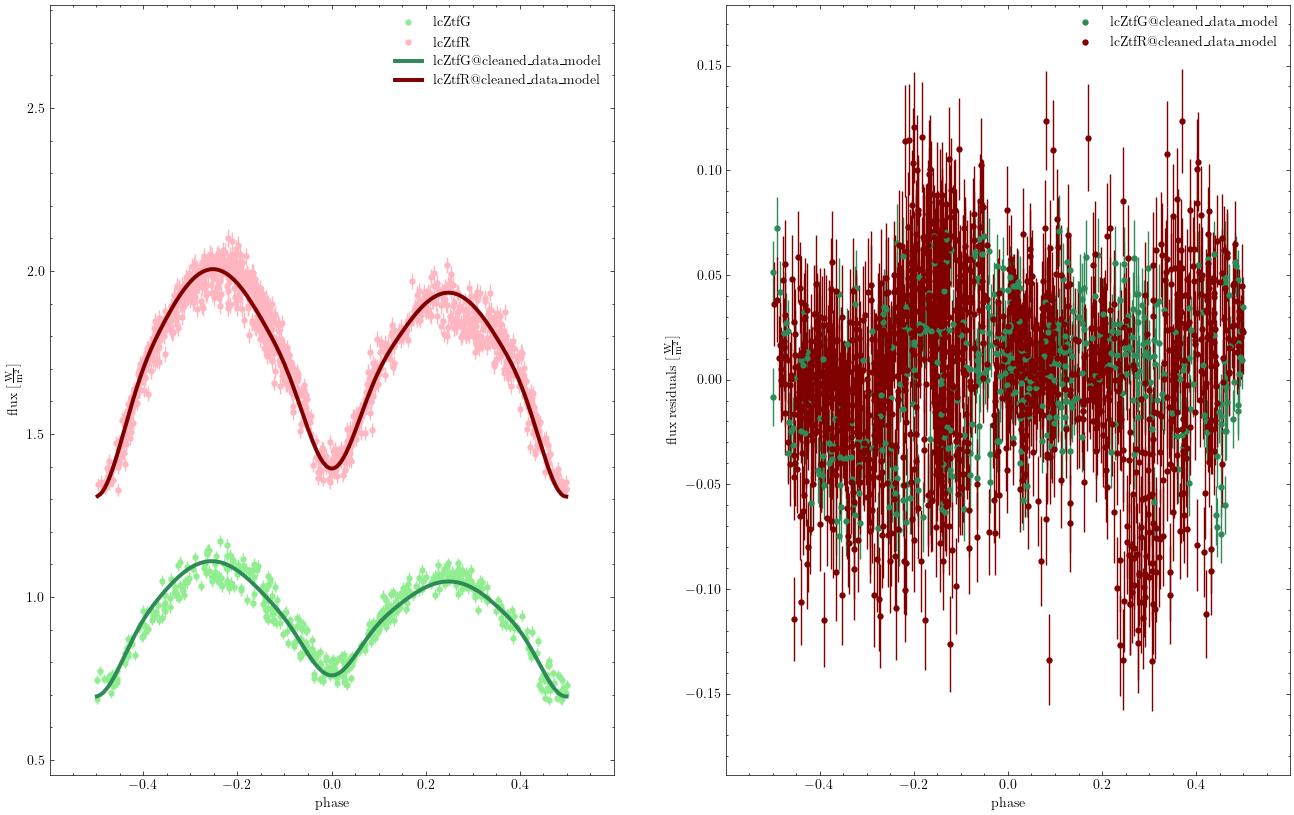

{'lcZtfG-lcZtfR': <Figure size 1600x1000 with 2 Axes>}

In [137]:
b.add_dataset('lc', dataset='lcZtfG', times=g_times[~g_badMask], fluxes=g_dataFlux[~g_badMask], sigmas=g_dataSigmas[~g_badMask], pblum_mode='component-coupled', pblum=b.get_quantity(qualifier='pblum', dataset='lcZtfG', context='dataset'), overwrite=True, passband='ZTF:g')
b.add_dataset('lc', dataset='lcZtfR', times=r_times[~r_badMask], fluxes=r_dataFlux[~r_badMask], sigmas=r_dataSigmas[~r_badMask], pblum_mode='dataset-coupled', pblum_dataset='lcZtfG', overwrite=True, passband='ZTF:r')

gen_utils.abilitateDatasets(b, ztfDatasets, False)
b.run_compute(model='cleaned_data_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[ztfDatasets], model='cleaned_data_model')

In [138]:
gen_utils.printAllModelsChi2(b)

before_data_removal
------------------------------------------------
------------------------------------------------
cleaned_data_model
------------------------------------------------
------------------------------------------------
	 ZTF - 6206.619590054457
		 lcZtfG - 1950.5477313711403
		 lcZtfR - 4256.071858683317


In [139]:
b.remove_models_all()

<ParameterSet: 19 parameters | contexts: model, figure>

In [140]:
b.datasets

['mesh01',
 'lc_iturbide_norm',
 'lc_gaia_g_raw',
 'lc_gaia_rp_raw',
 'lc_gaia_bp_raw',
 'lcGaiaG',
 'lcGaiaRP',
 'lcGaiaBP',
 'lcIturbide',
 'lcZtfG',
 'lcZtfR']

In [141]:
for d in ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lc_iturbide_norm']:
    b.remove_dataset(d)

In [142]:
b.datasets

['mesh01', 'lcGaiaG', 'lcGaiaRP', 'lcGaiaBP', 'lcIturbide', 'lcZtfG', 'lcZtfR']

In [143]:
for d in ztfDatasets:
    b.flip_constraint(qualifier='compute_phases', dataset=d, solve_for='compute_times')
    # b.flip_constraint(qualifier='compute_times', dataset=d, solve_for='compute_phases')

In [144]:
print(b['t0'])
print(b['t0_ref'])
print(b['t0_supconj'])
print(b['compute_times@lcZtfG'])

Parameter: t0@system
                       Qualifier: t0
                     Description: Time at which all values are provided.  For values with time-derivatives, this defines their zero-point.
                           Value: 0.0 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, mean_anom@binary@component
                      Related to: t0_supconj@binary@component, period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0_perpass@binary@component, t0_ref@binary@component, mean_anom@binary@component

ParameterSet: 2 parameters
C         t0_ref@binary@component: 0.02589 d
                t0_ref@constraint: t0_supconj_to_ref({t0_supconj@binary@component}, {period@binary@component}, {ecc@binary@component}, {per0@binary@component}, {dpdt@binary@component}, {dperdt@binary@component}, {t0@system})
Parameter: t0_supconj@binary@component
              

In [145]:
for d in gaiaDatasets + ['lcIturbide']:
    b.flip_constraint(qualifier='compute_phases', dataset=d, solve_for='compute_times')

100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


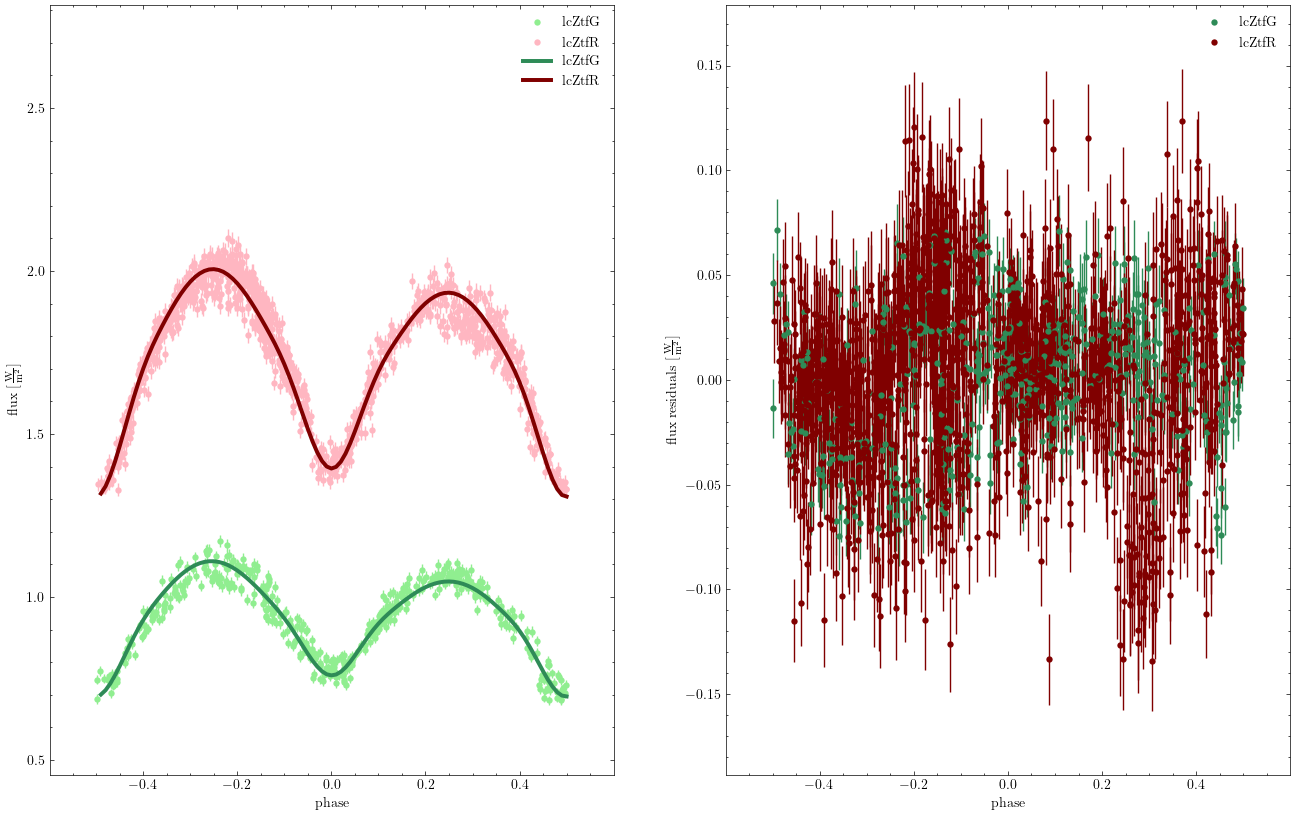

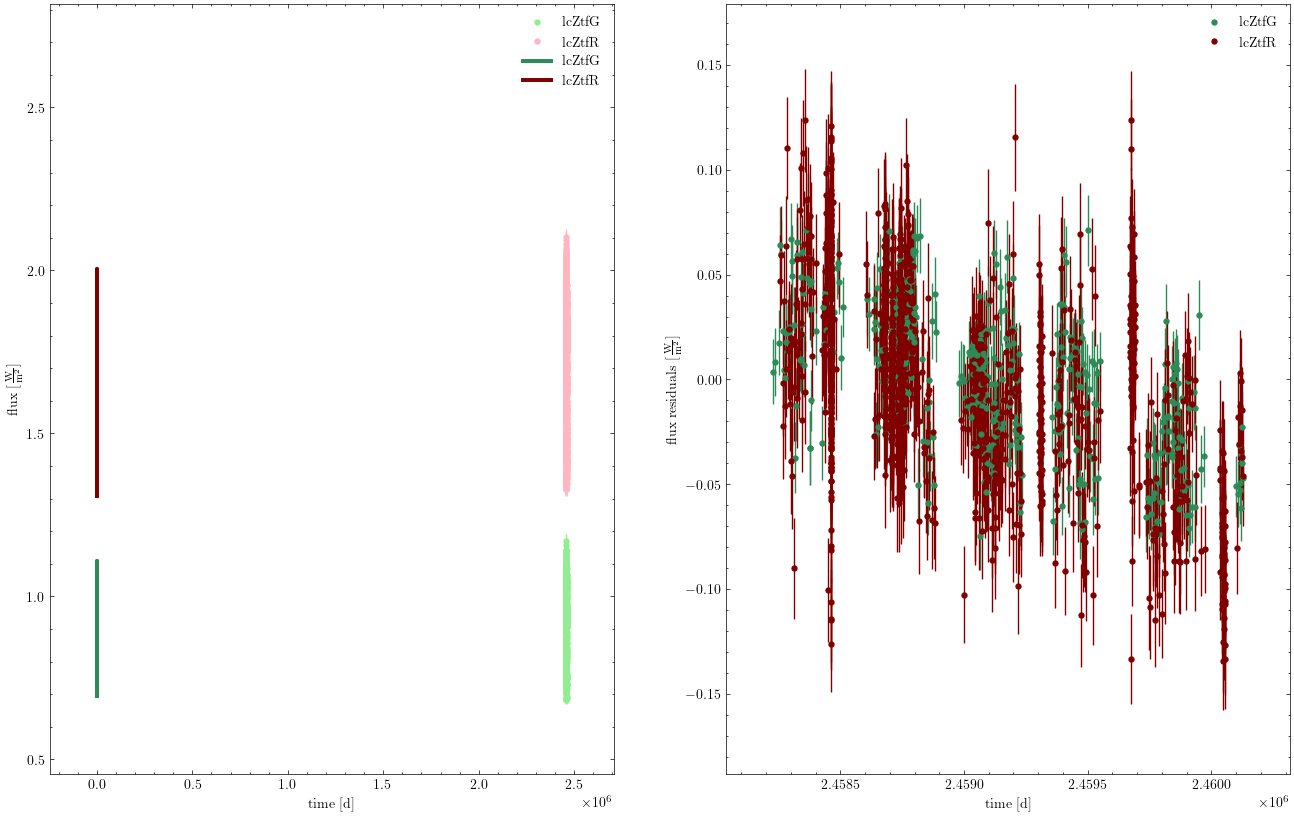

{'lcZtfG-lcZtfR': <Figure size 1600x1000 with 2 Axes>}

In [146]:
gen_utils.abilitateDatasets(b, ztfDatasets, False)
b.set_value_all(qualifier='compute_phases', dataset=ztfDatasets + gaiaDatasets + ['lcIturbide'], value=phoebe.linspace(-0.5, 0.5, num=101, endpoint=True))
b.run_compute(model='interp_compute_phases_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[ztfDatasets], model='interp_compute_phases_model')
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[ztfDatasets], model='interp_compute_phases_model', phase=False)

In [147]:
# gen_utils.saveBundle(b, "sigma_cleaned_ztf_data")
b.remove_models_all()
gen_utils.saveBundle(b, "sigma_cleaned_ztf_updated_data")

Sat, 03 Aug 2024 13:03 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/sigma_cleaned_ztf_updated_data.json.gz'